In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set()

from google.colab import drive
drive.mount('/content/drive')

sys.path.append("/content/drive/MyDrive/GSOC-NMR-project/Work/Notebooks")
from auxillary_functions import *
from polynomial_featextract import poly_featextract

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# import raw data and params.txt file
datadir_path = "/content/drive/MyDrive/GSOC-NMR-project/Work/Data/2021-06-21_classify_datagen_all_funcs"

rawdata = load_data(datadir_path)
params = load_params(datadir_path)
ker_integrals = load_wlist(datadir_path) # load wlist.txt file

# Stencil type : {'0' : 'Gaussian', '1' : 'Power Law', '2' : 'RKKY'}

Finished loading rawdata into numpy array
Finsihed loading parameters file
finished loading kernel-integrals file.


In [3]:
print(rawdata.shape)
offset = 150
# Length of the entire pulse is 3\tau. The 180-degree pulse occurs at \tau and
# the Echo-pulse occurs at 2\tau. So effectively, the Echo-pulse occurs at roughly 2/3*(len(tseries))

shifted_data, center = get_window(rawdata,2/3,width=offset)
print("The Echo pulse (180-pulse) occurs at timestep:",center)

# Rescaled data
rscl_data = shifted_data / np.max(shifted_data,axis=1,keepdims=True)

(10500, 943)
The Echo pulse (180-pulse) occurs at timestep: 628


In [4]:
rscl_df = pd.DataFrame(rscl_data, columns=[f"feat{i}" for i in range(rscl_data.shape[1])])
rscl_df.head()

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat13,feat14,feat15,feat16,feat17,feat18,feat19,feat20,feat21,feat22,feat23,feat24,feat25,feat26,feat27,feat28,feat29,feat30,feat31,feat32,feat33,feat34,feat35,feat36,feat37,feat38,feat39,...,feat260,feat261,feat262,feat263,feat264,feat265,feat266,feat267,feat268,feat269,feat270,feat271,feat272,feat273,feat274,feat275,feat276,feat277,feat278,feat279,feat280,feat281,feat282,feat283,feat284,feat285,feat286,feat287,feat288,feat289,feat290,feat291,feat292,feat293,feat294,feat295,feat296,feat297,feat298,feat299
0,0.007752,0.007970,0.007859,0.007362,0.006486,0.005304,0.003966,0.002714,0.001994,0.002240,0.003050,0.003977,0.004912,0.005853,0.006821,0.007831,0.008886,0.009962,0.010987,0.011842,0.012395,0.012538,0.012233,0.011535,0.010597,0.009640,0.008909,0.008615,0.008896,0.009777,0.011158,0.012818,0.014456,0.015753,0.016443,0.016368,0.015518,0.014031,0.012173,0.010274,...,0.007232,0.008779,0.010651,0.012499,0.013974,0.014804,0.014843,0.014102,0.012740,0.011034,0.009314,0.007892,0.007006,0.006765,0.007147,0.008007,0.009117,0.010217,0.011072,0.011524,0.011516,0.011093,0.010370,0.009490,0.008576,0.007702,0.006896,0.006155,0.005456,0.004751,0.003979,0.003113,0.002297,0.002097,0.002921,0.004195,0.005431,0.006386,0.006943,0.007078
1,0.007954,0.008204,0.008141,0.007703,0.006886,0.005750,0.004428,0.003127,0.002203,0.002156,0.002860,0.003798,0.004777,0.005768,0.006779,0.007827,0.008917,0.010024,0.011077,0.011962,0.012546,0.012728,0.012472,0.011835,0.010966,0.010080,0.009416,0.009176,0.009490,0.010383,0.011755,0.013390,0.014990,0.016243,0.016885,0.016765,0.015876,0.014360,0.012483,0.010577,...,0.007048,0.008521,0.010312,0.012065,0.013431,0.014139,0.014050,0.013184,0.011710,0.009914,0.008133,0.006691,0.005825,0.005651,0.006139,0.007133,0.008391,0.009640,0.010638,0.011223,0.011338,0.011026,0.010407,0.009622,0.008794,0.007998,0.007270,0.006617,0.006022,0.005428,0.004746,0.003904,0.002948,0.002241,0.002522,0.003646,0.004908,0.005939,0.006574,0.006770
2,0.008362,0.008377,0.008070,0.007380,0.006320,0.005004,0.003705,0.002974,0.003336,0.004407,0.005636,0.006833,0.007985,0.009136,0.010327,0.011577,0.012878,0.014184,0.015409,0.016428,0.017104,0.017328,0.017059,0.016351,0.015362,0.014322,0.013497,0.013124,0.013367,0.014270,0.015734,0.017530,0.019332,0.020792,0.021610,0.021597,0.020720,0.019109,0.017034,0.014844,...,0.006680,0.004955,0.003161,0.002609,0.003653,0.004712,0.005075,0.004610,0.003449,0.001902,0.000592,0.001249,0.001900,0.001845,0.001082,0.000412,0.001964,0.003593,0.004948,0.005842,0.006216,0.006138,0.005770,0.005298,0.004852,0.004459,0.004079,0.003681,0.003262,0.002817,0.002313,0.001764,0.001522,0.002185,0.003444,0.004810,0.005980,0.006746,0.006991,0.006697
3,0.071041,0.116141,0.157928,0.186144,0.193928,0.176297,0.131342,0.063197,0.047574,0.143523,0.244109,0.331524,0.394783,0.427744,0.430725,0.411673,0.385972,0.372340,0.382148,0.410700,0.443466,0.467947,0.478935,0.478557,0.474363,0.476278,0.492618,0.526711,0.576429,0.636274,0.699532,0.759315,0.808905,0.842098,0.853650,0.839802,0.798746,0.730959,0.639387,0.529448,...,0.235294,0.135007,0.063859,0.099112,0.173708,0.244687,0.307738,0.362627,0.409473,0.448187,0.478734,0.501774,0.519287,0.534609,0.551404,0.571638,0.593824,0.613037,0.622808,0.617796,0.595924,0.559370,0.514321,0.469429,0.433229,0.411235,0.404521,0.410693,0.425682,0.444243,0.459769,0.464925,0.453342,0.421539,0.370215,0.304493,0.233116,0.166677,0.114716,0.081142
4,0.008419,0.008817,0.008915,0.008637,0.007955,0.006909,0.005599,0.004194,0.002949,0.002305,0.002617,0.003497,0.004533,0.005599,0.006677,0.007779,0.008908,0.010039,0.011106,0.012004,0.012620,0.012869,0.012727,0.012255,0.011597,0.010952,0.010531,0.010513,0.011006,0.012017,0.013439,0.015058,0.016584,0.017720,0.018223,0.017961,0.016947,0.015341,0.013419,0.011513,...,0.006159,0.007627,0.009420,0.011146,0.012434,0.013009,0.012752,0.011716,0.010124,0.008314,0.006670,0.005512,0.004990,0.005112,0.005866,

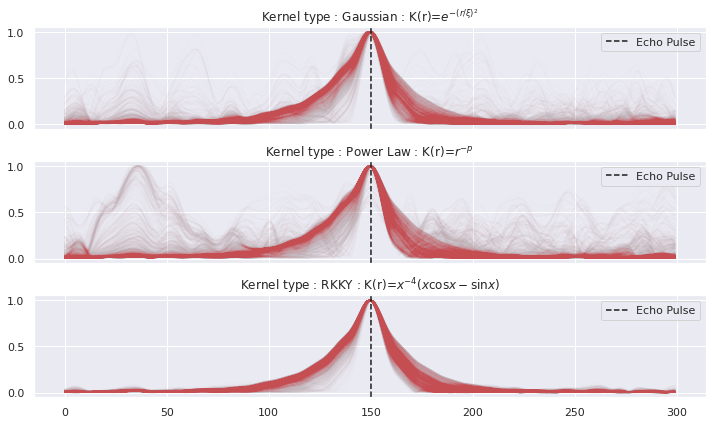

In [5]:
fig, axes = plt.subplots(3,1, figsize=(10,6),sharex=True,sharey=True)
func_type = ['Gaussian : K(r)='+r'$e^{-(r/ \xi)^2}$',
             'Power Law : K(r)='+r'$r^{-p}$',
             'RKKY : K(r)='+r'$x^{-4}(x \cos{x} - \sin{x} )$']

ncurves = lambda x : np.random.randint(0,3500, x)

for id, ax in enumerate(axes):
    for row in rscl_data[params["stencil_type"] == id,:][ncurves(1500)] :
        ax.plot(row, color='r', alpha=0.009)
    ax.set_title(f"Kernel type : {func_type[id]}")
    ax.axvline(x=150, color='k',ls='--',label='Echo Pulse')
    ax.legend()

plt.tight_layout()
plt.show()

# Regression

In [180]:
!pip uninstall scikit-learn -y

!pip install -U scikit-learn

Uninstalling scikit-learn-0.22.2.post1:
  Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 22.3MB 4.2MB/s 


In [6]:
import sklearn
sklearn.__version__

'0.24.2'

In [7]:
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree

In [109]:
?cross_validate

In [8]:
# Since αx & αy are the same. We will use only αx fro regression

y = params[['αx','αz']]

split_vals = lambda pred_col : train_test_split(rscl_df, pred_col,
                                                test_size=0.2, random_state=42,
                                                stratify=params.stencil_type)

x_train_ax, x_test_ax, y_train_ax, y_test_ax = split_vals(y['αx'])
x_train_az, x_test_az, y_train_az, y_test_az = split_vals(y['αz'])

### Decision Tree with cost-complexity pruning

The `class:DecisionTreeClassifier` provides parameters such as `min_samples_leaf` and `max_depth` to prevent a tree from overfiting. Cost complexity pruning provides another option to control the size of a tree. In `class:DecisionTreeClassifier` , this pruning technique is parameterized by the cost complexity parameter, `ccp_alpha`. Greater values of ccp_alpha increase the number of nodes pruned. Here we only show the effect of ccp_alpha on regularizing the trees and how to choose a ccp_alpha based on validation scores.

See also minimal_cost_complexity_pruning for details on pruning.

In [9]:
clf = DecisionTreeRegressor(random_state=42)
clf.fit(x_train_ax, y_train_ax)

DecisionTreeRegressor(random_state=42)

In [10]:
pred = clf.predict(x_test_ax)
from sklearn.metrics import r2_score, mean_squared_log_error
print("$R^2$ value$: ",r2_score(y_test_ax, pred) )
print("Log loss:", mean_squared_log_error(y_test_ax, pred))

$R^2$ value$:  0.8953073722898278
Log loss: 1.5489882313635443e-06


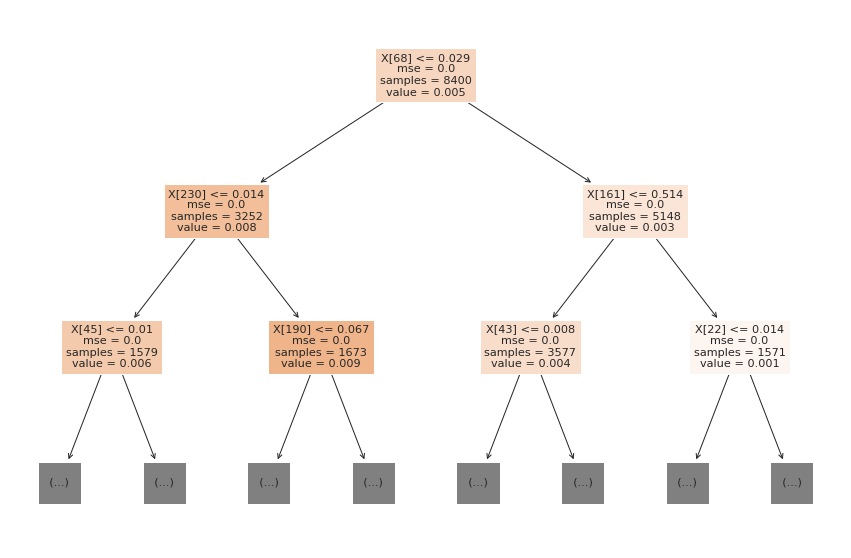

In [16]:
plt.figure(figsize=(15,10))
plot_tree(clf, max_depth=2,filled=True )
plt.show()

In [17]:
path = clf.cost_complexity_pruning_path(x_train_ax, y_train_ax)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [ ]:
impurities

In [20]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(x_train_ax, y_train_ax)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

KeyboardInterrupt: ignored

#### Accuracy vs alpha for training and testing sets

In [ ]:
train_scores = [clf.score(x_train_ax, y_train_ax) for clf in clfs]
test_scores = [clf.score(x_test_ax, y_test_ax) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

### Random Forest

In [125]:
def rmse(x,y): return np.sqrt(((x-y)**2).mean())

def print_score(model, X_train, X_test, y_train, y_test):
    res = [rmse(model.predict(X_train), y_train), rmse(model.predict(X_test), y_test),
                model.score(X_train, y_train), model.score(X_test, y_test)]
    if hasattr(model, 'oob_score_'): res.append(model.oob_score_)
    print(res)

In [84]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x_train_ax, y_train_ax)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [93]:
print_score(m, x_train_ax, x_test_ax, y_train_ax, y_test_ax)

[0.0003737012870381687, 0.0007571627551263143, 0.9907744584808389, 0.9618666192626298, 0.9568299733929706]


## Feature importance

In [ ]:
scores

In [ ]:
imp_array = []
for model in models:
    imp_array.append(model.feature_importances_)

In [ ]:
imp_df = pd.DataFrame(np.array(imp_array).T, columns=['FE_αx',"FE_αy", "FE_αz"])

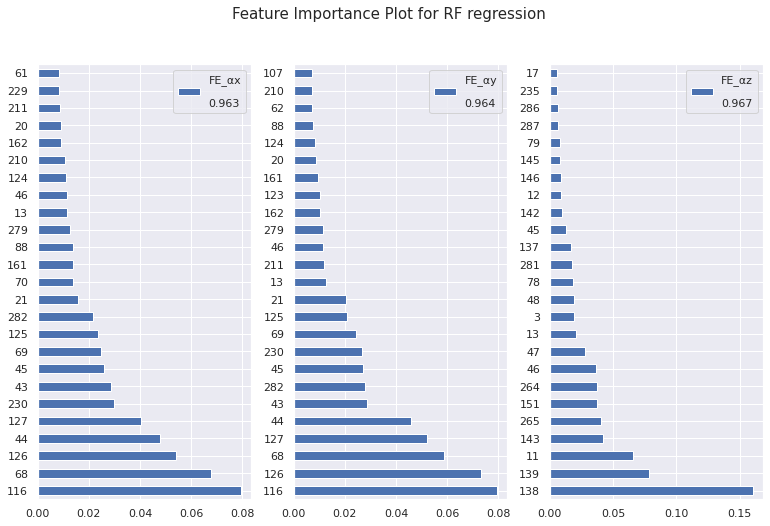

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(13,8))

for idx, col in enumerate(imp_df.columns.tolist()):
    imp_df.sort_values(col, ascending=False)[col].head(25).plot.barh(ax=axes[idx],
                                                                     label=col+'\n \n'+
                                                                     f'{scores[idx]:.3}')
    axes[idx].legend()

plt.suptitle("Feature Importance Plot for RF regression", fontsize=15)
plt.show()

In [2]:
params

NameError: ignored

In [ ]:
imp_df = pd.DataFrame(model.feature_importances_, columns=["FE"])


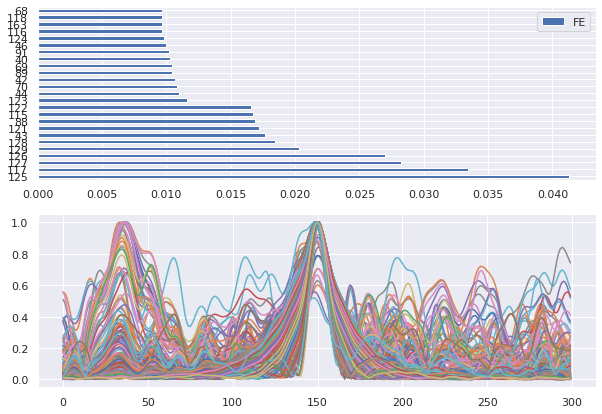

In [ ]:
fig,axes = plt.subplots(2,1,figsize=(10,7))

imp_df.sort_values("FE", ascending=False).head(25).plot.barh(ax=axes[0])

for i in np.random.randint(low=0,high=10500, size=1000):
    axes[1].plot(rscl_data[i,:])